In [3]:
#!pip show fastai
#!pip install fastai --upgrade
#!pip install libauc

In [4]:
from fastai.vision.all import *
import pandas as pd
import sys
sys.path.insert(0,'/content/chexpert/models/')
import cam
import util

In [5]:
# Use small bs as we have very limited data due to conditional hierarchy filtering
dls, labels = util.chexpert_data_loader(use_hierarchy=True, bs=4)

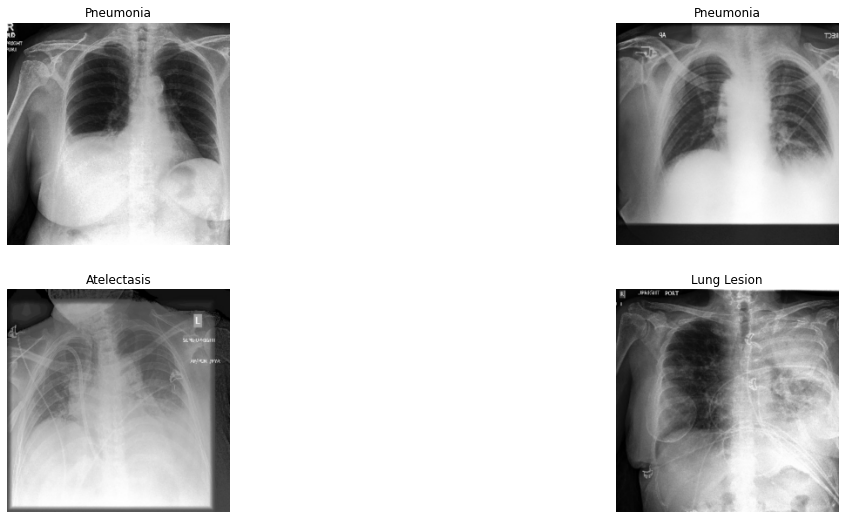

In [6]:
dls.show_batch(max_n=9, figsize=(20,9))

In [7]:
# First train on conditional probabilities
chexpert_learner_conditional = util.ChexpertLearner(dls, xse_resnext50, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

lr_min/10: 3.311311274956097e-07, lr_steep: 6.309573450380412e-07, base_lr: 6.309573450380412e-07


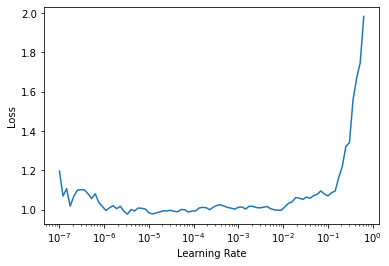

In [8]:
chexpert_learner_conditional.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,1.075992,0.803435,[0.47747591 0.48354895 0.56737348 0.50711047],0.503505,00:56


Better model found at epoch 0 with valid_loss value: 0.8034347891807556.


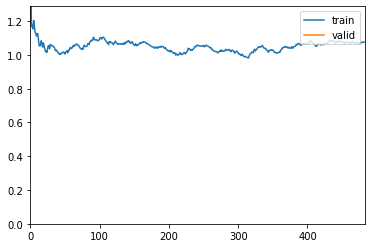

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,1.049394,0.842642,[0.4968652 0.49662587 0.57763642 0.49698894],0.509571,01:16
1,1.050606,0.778923,[0.51062348 0.51898601 0.56991801 0.51296935],0.523799,01:16
2,1.051070,0.792459,[0.50670498 0.48524476 0.57769296 0.52733539],0.516778,01:15
3,1.009216,0.840058,[0.494398 0.48940559 0.59089624 0.50593143],0.511556,01:15
4,1.021709,0.778485,[0.51674794 0.50410839 0.56494204 0.49651732],0.513179,01:16
5,1.059519,0.772708,[0.54438059 0.51853147 0.56853265 0.49842191],0.523845,01:15
6,0.999643,0.787473,[0.52722629 0.51101399 0.56904156 0.49459459],0.517322,01:15
7,1.031674,0.809559,[0.5309416 0.51363636 0.59898219 0.50553238],0.527123,01:15
8,1.029633,0.745849,[0.52475909 0.53851399 0.57687306 0.52670053],0.538637,01:16
9,1.041587,0.793749,[0.5211889 0.53375874 0.61713316 0.53542536],0.545545,01:16


Better model found at epoch 0 with valid_loss value: 0.8426420092582703.


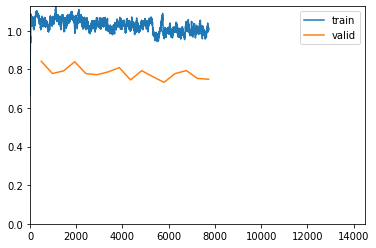

Better model found at epoch 1 with valid_loss value: 0.7789230942726135.
Epoch 3: reducing lr to 1.6728446659324337e-08
Better model found at epoch 4 with valid_loss value: 0.7784848213195801.
Better model found at epoch 5 with valid_loss value: 0.7727081775665283.
Epoch 7: reducing lr to 3.078371696672106e-08
Better model found at epoch 8 with valid_loss value: 0.7458486557006836.
Epoch 10: reducing lr to 3.084852222472093e-08
Better model found at epoch 11 with valid_loss value: 0.7332125902175903.
Epoch 13: reducing lr to 2.7340410654116618e-08
Epoch 15: reducing lr to 2.3665209394444415e-08
No improvement since epoch 11: early stopping


In [9]:
chexpert_learner_conditional.learn_model(use_saved=False, epochs=30)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


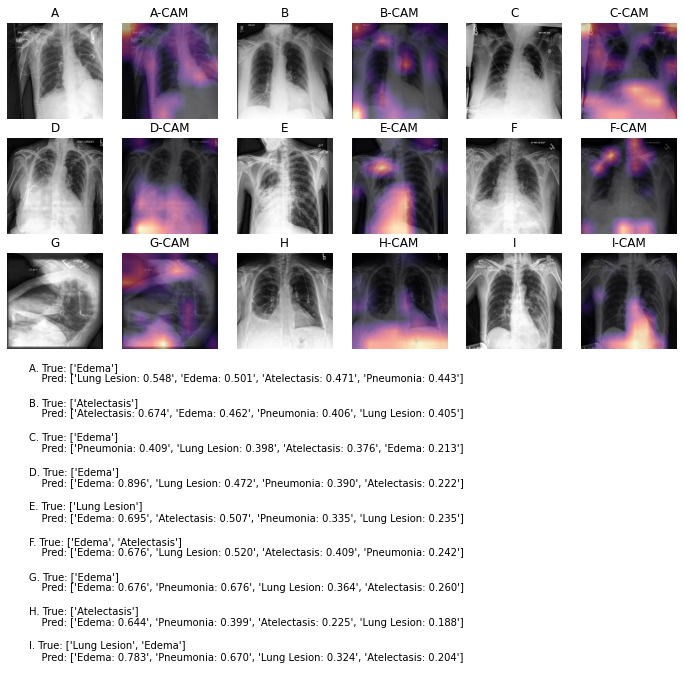

In [11]:
# Let us see how the conditional model predicts - use the saved optimal model
chexpert_learner = cnn_learner(dls, xse_resnext50, path=Path('/content/chexpert/saves/'))
chexpert_learner.load('xse_resnext50-chexpert', with_opt=True)
cam.plot_cam(chexpert_learner)

In [12]:
# Reload the data as it may have been modified for conditional probs
dls, labels = util.chexpert_data_loader()

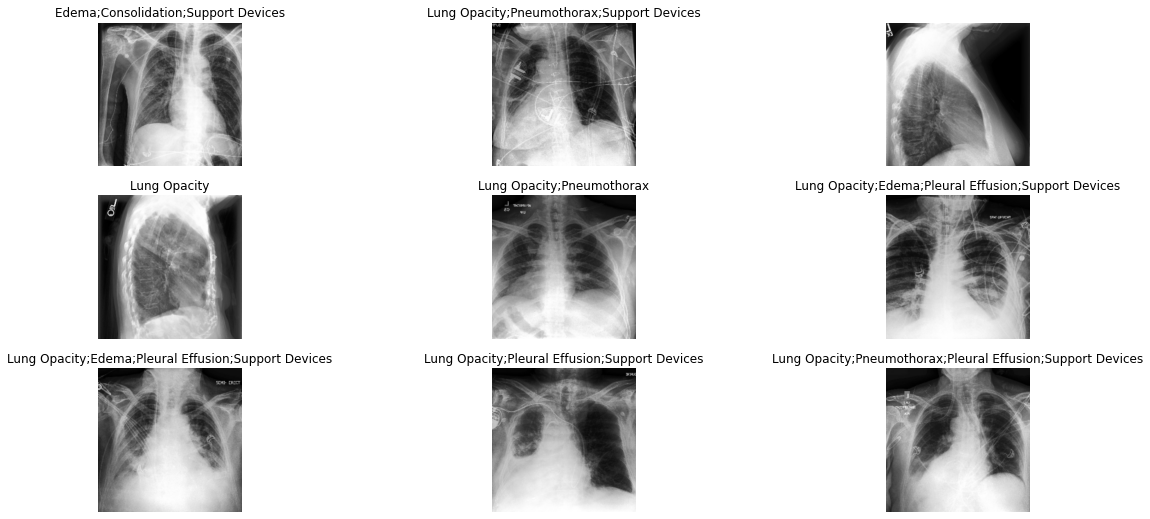

In [13]:
dls.show_batch(max_n=9, figsize=(20,9))

In [14]:
# Next train unconditionally for only transfer learning
chexpert_learner_unconditional = util.ChexpertLearner(dls, xse_resnext50, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

lr_min/10: 0.014454397559165954, lr_steep: 0.03981071710586548, base_lr: 0.03981071710586548


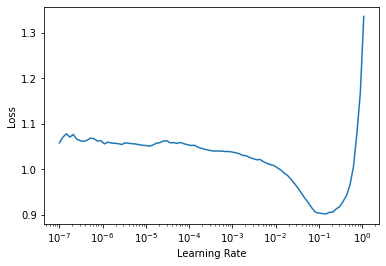

In [15]:
chexpert_learner_unconditional.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.328889,0.325304,[0.80070696 0.56043832 0.66651022 0.66825565 0.65397868 0.76753458 0.63826096 0.60364125 0.61366632 0.71008714 0.75510308 0.70640227 0.62536512 0.75218095],0.710601,31:02
1,0.324905,0.320630,[0.81090079 0.56719545 0.69540416 0.6740423 0.66491934 0.7791505 0.65313593 0.6253337 0.62353053 0.73053492 0.77309943 0.71171218 0.65087731 0.76458315],0.723649,31:02
2,0.322105,0.318896,[0.81955688 0.55965653 0.72083337 0.67984772 0.6729704 0.78533456 0.64664841 0.62972535 0.62887908 0.73568718 0.78511043 0.71479819 0.65515777 0.76637739],0.730102,31:02
3,0.325635,0.318455,[0.82172768 0.583182 0.7315972 0.68270224 0.67416507 0.78672047 0.65177022 0.63960433 0.63297705 0.73684766 0.79036357 0.70859995 0.64003198 0.77360638],0.734774,31:03
4,0.327083,0.315884,[0.82739146 0.57709792 0.73636671 0.68050328 0.67159906 0.7903319 0.65013531 0.61513089 0.62635141 0.74799437 0.79728897 0.7168459 0.65841592 0.77233754],0.735909,31:04
5,0.322755,0.315784,[0.82651648 0.57760911 0.74470142 0.68482902 0.67098233 0.7899929 0.65017431 0.6363088 0.62923259 0.74342136 0.80209715 0.71587307 0.64482044 0.77022321],0.737529,31:02
6,0.329823,0.326148,[0.83211886 0.57555151 0.7537851 0.68215521 0.66526814 0.7929227 0.65973535 0.61259988 0.62801465 0.73855415 0.80316591 0.70594108 0.6445107 0.76686837],0.736939,31:03
7,0.325153,0.329387,[0.8283993 0.57274602 0.75867667 0.6823756 0.65111365 0.78670165 0.64544901 0.6274831 0.63185054 0.74399478 0.80816128 0.69336507 0.65342965 0.77013257],0.738014,31:03
8,0.329093,0.333552,[0.82751525 0.55407319 0.76063347 0.6799511 0.63756389 0.78386932 0.65613148 0.60282452 0.62575176 0.71888761 0.80989937 0.69243543 0.63665172 0.77102342],0.735529,31:03
9,0.325399,0.383244,[0.82662817 0.5837162 0.76590235 0.67989261 0.6621418 0.78272705 0.63701533 0.59691885 0.62839641 0.73052254 0.8069942 0.69394461 0.62854818 0.76605856],0.734956,31:04


Better model found at epoch 0 with valid_loss value: 0.3253036141395569.


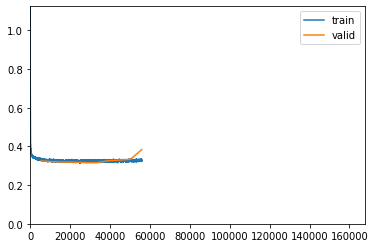

Better model found at epoch 1 with valid_loss value: 0.3206304609775543.
Better model found at epoch 2 with valid_loss value: 0.31889626383781433.
Better model found at epoch 3 with valid_loss value: 0.3184548020362854.
Better model found at epoch 4 with valid_loss value: 0.31588369607925415.
Better model found at epoch 5 with valid_loss value: 0.3157840967178345.
Epoch 7: reducing lr to 0.0008035414847734311
Epoch 9: reducing lr to 0.0011322269147360825
No improvement since epoch 5: early stopping


In [16]:
# Freeze the body and update the weights for the last layer
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, old_learner=chexpert_learner_conditional.learn, epochs=0, freeze_epochs=30)

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.316159,0.317624,[0.83301096 0.58897047 0.76999989 0.68692823 0.69116928 0.7940994 0.656947 0.65334023 0.63778634 0.74525195 0.81292173 0.71483026 0.6640514 0.77595782],0.745066,42:09
1,0.319706,0.315202,[0.83829689 0.5791157 0.78567404 0.68846743 0.67460617 0.7997709 0.64676726 0.64259098 0.63748598 0.75948152 0.82465042 0.72223709 0.66462915 0.78760194],0.751233,42:09
2,0.319566,0.360742,[0.83158319 0.57669548 0.78729505 0.68827372 0.6828561 0.8023157 0.6714549 0.66920333 0.64298449 0.76819231 0.8298785 0.69568762 0.6662213 0.78903477],0.754100,42:10
3,0.319610,0.355783,[0.83730198 0.51918521 0.77135309 0.68683043 0.60125921 0.80025351 0.65730366 0.63640681 0.64063605 0.7438462 0.82604087 0.69323446 0.64052573 0.77863637],0.745009,42:15
4,0.321118,0.408115,[0.84117752 0.58435015 0.79670382 0.68513035 0.68318036 0.80146227 0.65322573 0.66857159 0.6457224 0.75426439 0.82826779 0.66627998 0.64057488 0.79432358],0.753856,42:15
5,0.320001,0.408644,[0.84231348 0.55604938 0.78827883 0.6946494 0.68992735 0.79542389 0.67137736 0.66684144 0.64179737 0.77624341 0.84102426 0.71363664 0.64763154 0.80639343],0.760662,42:13


Better model found at epoch 0 with valid_loss value: 0.3176242411136627.


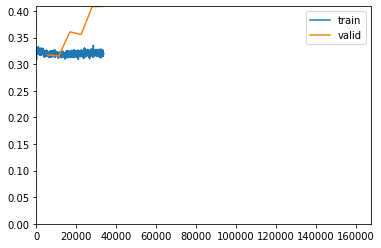

Better model found at epoch 1 with valid_loss value: 0.315201997756958.
Epoch 3: reducing lr to 0.0010560113112227194
Epoch 5: reducing lr to 0.001592385600706532


epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.316159,0.317624,[0.83301096 0.58897047 0.76999989 0.68692823 0.69116928 0.7940994 0.656947 0.65334023 0.63778634 0.74525195 0.81292173 0.71483026 0.6640514 0.77595782],0.745066,42:09
1,0.319706,0.315202,[0.83829689 0.5791157 0.78567404 0.68846743 0.67460617 0.7997709 0.64676726 0.64259098 0.63748598 0.75948152 0.82465042 0.72223709 0.66462915 0.78760194],0.751233,42:09
2,0.319566,0.360742,[0.83158319 0.57669548 0.78729505 0.68827372 0.6828561 0.8023157 0.6714549 0.66920333 0.64298449 0.76819231 0.8298785 0.69568762 0.6662213 0.78903477],0.754100,42:10
3,0.319610,0.355783,[0.83730198 0.51918521 0.77135309 0.68683043 0.60125921 0.80025351 0.65730366 0.63640681 0.64063605 0.7438462 0.82604087 0.69323446 0.64052573 0.77863637],0.745009,42:15
4,0.321118,0.408115,[0.84117752 0.58435015 0.79670382 0.68513035 0.68318036 0.80146227 0.65322573 0.66857159 0.6457224 0.75426439 0.82826779 0.66627998 0.64057488 0.79432358],0.753856,42:15
5,0.320001,0.408644,[0.84231348 0.55604938 0.78827883 0.6946494 0.68992735 0.79542389 0.67137736 0.66684144 0.64179737 0.77624341 0.84102426 0.71363664 0.64763154 0.80639343],0.760662,42:13
6,0.326547,0.515217,[0.84702077 0.58301803 0.79703914 0.69573513 0.68937762 0.80576779 0.62501133 0.67037856 0.64435895 0.7903831 0.83626393 0.70110046 0.65524942 0.81971453],0.764813,42:16


No improvement since epoch 1: early stopping


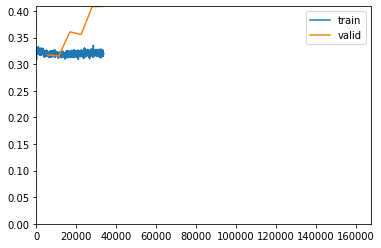

In [17]:
# Unfreeze the body and update the whole model end-to-end
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, epochs=30, freeze_epochs=0)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


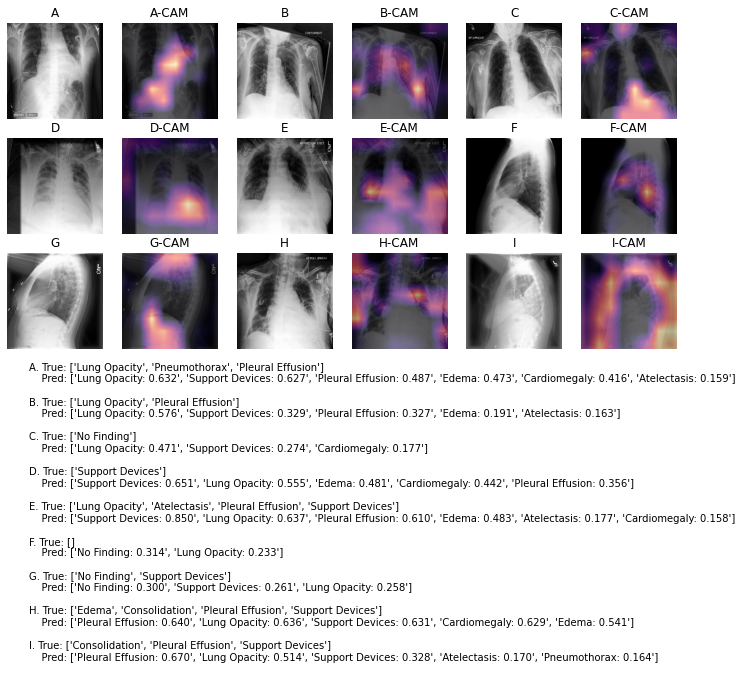

In [19]:
chexpert_learner = cnn_learner(dls, xse_resnext50, path=Path('/content/chexpert/saves/'))
chexpert_learner.load('xse_resnext50-chexpert', with_opt=True)
cam.plot_cam(chexpert_learner)

In [20]:
# Save the final model
chexpert_learner_unconditional.learn.save('xse_resnext50-chexpert-final')

Path('/content/chexpert/saves/models/xse_resnext50-chexpert-final.pth')